In [1]:
!pip install kaggle

In [2]:
import xgboost as xgb
from xgboost import XGBClassifier
import time
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
news_df = pd.read_csv('/content/drive/MyDrive/QuantProjects/news_sample.csv')
market_df = pd.read_csv('/content/drive/MyDrive/QuantProjects/marketdata_sample.csv')

In [5]:
news_df.head()

,time,sourceTimestamp,firstCreated,sourceId,headline,urgency,takeSequence,provider,subjects,audiences,...,noveltyCount12H,noveltyCount24H,noveltyCount3D,noveltyCount5D,noveltyCount7D,volumeCounts12H,volumeCounts24H,volumeCounts3D,volumeCounts5D,volumeCounts7D
0,2007-01-01 04:29:32+00:00,2007-01-01 04:29:32+00:00,2007-01-01 04:29:32+00:00,e58c6279551b85cf,China's Daqing pumps 43.41 mln tonnes of oil i...,3,1,RTRS,"{'CRU', 'CN', 'RTRS', 'ENR', 'LEN', 'EMRG', 'N...","{'O', 'Z', 'OIL'}",...,0,0,0,0,0,0,0,3,6,7
1,2007-01-01 07:03:35+00:00,2007-01-01 07:03:34+00:00,2007-01-01 07:03:34+00:00,5a31c4327427f63f,"FEATURE-In kidnapping, finesse works best",3,1,RTRS,"{'BD', 'INS', 'LATAM', 'CA', 'US', 'MX', 'IL',...","{'PGE', 'PCU', 'PCO', 'DNP', 'MD', 'E', 'G', '...",...,1,1,1,1,1,1,1,3,3,3
2,2007-01-01 11:29:56+00:00,2007-01-01 11:29:56+00:00,2007-01-01 11:29:56+00:00,1cefd27a40fabdfe,PRESS DIGEST - Wall Street Journal - Jan 1,3,1,RTRS,"{'IQ', 'RO', 'US', 'ID', 'RET', 'RTRS', 'ENR',...","{'M', 'PMF', 'DNP', 'PTD', 'T', 'E', 'D', 'PSC...",...,0,0,0,0,0,0,0,5,11,17
3,2007-01-01 12:08:37+00:00,2007-01-01 12:08:37+00:00,2007-01-01 12:08:37+00:00,23768af19dc69992,PRESS DIGEST - New York Times - Jan 1,3,1,RTRS,"{'PUB', 'BUS', 'INS', 'CA', 'ENT', 'US', 'FIN'...","{'M', 'PMF', 'DNP', 'PTD', 'T', 'E', 'D', 'PSC...",...,0,0,0,0,0,0,0,5,13,15
4,2007-01-01 12:08:37+00:00,2007-01-01 12:08:37+00:00,2007-01-01 12:08:37+00:00,23768af19dc69992,PRESS DIGEST - New York Times - Jan 1,3,1,RTRS,"{'PUB', 'BUS', 'INS', 'CA', 'ENT', 'US', 'FIN'...","{'M', 'PMF', 'DNP', 'PTD', 'T', 'E', 'D', 'PSC...",...,0,0,0,0,0,0,0,0,0,0


In [6]:
market_df.head()

,time,assetCode,assetName,universe,volume,close,open,returnsClosePrevRaw1,returnsOpenPrevRaw1,returnsClosePrevMktres1,returnsOpenPrevMktres1,returnsClosePrevRaw10,returnsOpenPrevRaw10,returnsClosePrevMktres10,returnsOpenPrevMktres10,returnsOpenNextMktres10
0,2007-02-01 22:00:00+00:00,A.N,Agilent Technologies Inc,1.0,2606900.0,32.19,32.17,0.005938,0.005312,NaN,NaN,-0.001860,0.000622,NaN,NaN,0.034672
1,2007-02-01 22:00:00+00:00,AAI.N,AirTran Holdings Inc,0.0,2051600.0,11.12,11.08,0.004517,-0.007168,NaN,NaN,-0.078708,-0.088066,NaN,NaN,0.027803
2,2007-02-01 22:00:00+00:00,AAP.N,Advance Auto Parts Inc,1.0,1164800.0,37.51,37.99,-0.011594,0.025648,NaN,NaN,0.014332,0.045405,NaN,NaN,0.024433
3,2007-02-01 22:00:00+00:00,AAPL.O,Apple Inc,1.0,23747329.0,84.74,86.23,-0.011548,0.016324,NaN,NaN,-0.048613,-0.037182,NaN,NaN,-0.007425
4,2007-02-01 22:00:00+00:00,ABB.N,ABB Ltd,1.0,1208600.0,18.02,18.01,0.011791,0.025043,NaN,NaN,0.012929,0.020397,NaN,NaN,-0.017994


In [7]:
news_df['time'] = pd.to_datetime(news_df['time'])
news_df['sourceTimestamp'] = pd.to_datetime(news_df['sourceTimestamp'])
market_df['time'] = pd.to_datetime(market_df['time'])

In [8]:
merged_df = pd.merge(news_df, market_df, on='time', how='outer')

In [9]:
merged_df.head()

,time,sourceTimestamp,firstCreated,sourceId,headline,urgency,takeSequence,provider,subjects,audiences,...,open,returnsClosePrevRaw1,returnsOpenPrevRaw1,returnsClosePrevMktres1,returnsOpenPrevMktres1,returnsClosePrevRaw10,returnsOpenPrevRaw10,returnsClosePrevMktres10,returnsOpenPrevMktres10,returnsOpenNextMktres10
0,2007-01-01 04:29:32+00:00,2007-01-01 04:29:32+00:00,2007-01-01 04:29:32+00:00,e58c6279551b85cf,China's Daqing pumps 43.41 mln tonnes of oil i...,3.0,1.0,RTRS,"{'CRU', 'CN', 'RTRS', 'ENR', 'LEN', 'EMRG', 'N...","{'O', 'Z', 'OIL'}",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2007-01-01 07:03:35+00:00,2007-01-01 07:03:34+00:00,2007-01-01 07:03:34+00:00,5a31c4327427f63f,"FEATURE-In kidnapping, finesse works best",3.0,1.0,RTRS,"{'BD', 'INS', 'LATAM', 'CA', 'US', 'MX', 'IL',...","{'PGE', 'PCU', 'PCO', 'DNP', 'MD', 'E', 'G', '...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2007-01-01 11:29:56+00:00,2007-01-01 11:29:56+00:00,2007-01-01 11:29:56+00:00,1cefd27a40fabdfe,PRESS DIGEST - Wall Street Journal - Jan 1,3.0,1.0,RTRS,"{'IQ', 'RO', 'US', 'ID', 'RET', 'RTRS', 'ENR',...","{'M', 'PMF', 'DNP', 'PTD', 'T', 'E', 'D', 'PSC...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2007-01-01 12:08:37+00:00,2007-01-01 12:08:37+00:00,2007-01-01 12:08:37+00:00,23768af19dc69992,PRESS DIGEST - New York Times - Jan 1,3.0,1.0,RTRS,"{'PUB', 'BUS', 'INS', 'CA', 'ENT', 'US', 'FIN'...","{'M', 'PMF', 'DNP', 'PTD', 'T', 'E', 'D', 'PSC...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2007-01-01 12:08:37+00:00,2007-01-01 12:08:37+00:00,2007-01-01 12:08:37+00:00,23768af19dc69992,PRESS DIGEST - New York Times - Jan 1,3.0,1.0,RTRS,"{'PUB', 'BUS', 'INS', 'CA', 'ENT', 'US', 'FIN'...","{'M', 'PMF', 'DNP', 'PTD', 'T', 'E', 'D', 'PSC...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
merged_df.tail()

,time,sourceTimestamp,firstCreated,sourceId,headline,urgency,takeSequence,provider,subjects,audiences,...,open,returnsClosePrevRaw1,returnsOpenPrevRaw1,returnsClosePrevMktres1,returnsOpenPrevMktres1,returnsClosePrevRaw10,returnsOpenPrevRaw10,returnsClosePrevMktres10,returnsOpenPrevMktres10,returnsOpenNextMktres10
195,2007-02-01 22:00:00+00:00,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,67.81,0.000886,0.019086,NaN,NaN,0.052321,0.041308,NaN,NaN,-0.012906
196,2007-02-01 22:00:00+00:00,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,16.01,-0.045970,-0.030872,NaN,NaN,-0.158333,-0.119217,NaN,NaN,0.136984
197,2007-02-01 22:00:00+00:00,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,43.40,-0.010138,0.009302,NaN,NaN,0.040698,0.051357,NaN,NaN,0.064169
198,2007-02-01 22:00:00+00:00,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,24.73,-0.026149,-0.010404,NaN,NaN,0.000000,-0.005629,NaN,NaN,0.068776
199,2007-02-01 22:00:00+00:00,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,26.82,0.009701,0.009409,NaN,NaN,0.040769,0.041958,NaN,NaN,0.030822


In [11]:
best_cols = ['volume', 'close', 'open', 'returnsClosePrevRaw1', 'returnsOpenPrevRaw1',
       'returnsClosePrevMktres1',
       'returnsClosePrevRaw10', 'returnsOpenPrevRaw10',
       'returnsClosePrevMktres10', 'returnsOpenPrevMktres10',
             'MA_15MA','MA_30MA', 'MA_45MA', 'MA_60MA', 'MA_80MA']

In [12]:
merged_df['year'] = merged_df['time'].dt.year
merged_df['week'] = merged_df['time'].dt.isocalendar().week
merged_df['dayofweek'] = merged_df['time'].dt.dayofweek
merged_df['day'] = merged_df['time'].dt.day

In [13]:
merged_df['MA_15MA'] = merged_df['close'].rolling(window=15).mean()
merged_df['MA_30MA'] = merged_df['close'].rolling(window=30).mean()
merged_df['MA_45MA'] = merged_df['close'].rolling(window=45).mean()
merged_df['MA_60MA'] = merged_df['close'].rolling(window=60).mean()
merged_df['MA_80MA'] = merged_df['close'].rolling(window=80).mean()

In [14]:
X_train = merged_df[best_cols]
y_train = merged_df.returnsOpenNextMktres10 >= 0
y_train = y_train.values

In [15]:
X_train_valid, X_test_valid, y_train_valid, y_test_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [17]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.9 MB/s eta 0:00:00


In [20]:
import catboost
from catboost import CatBoostClassifier
import time

In [23]:
for deph in [4]: begin_time = time.time()
model = CatBoostClassifier(n_estimators=250, max_depth = deph, eta=0.1, random_seed=42)

In [24]:
model.fit(X_train_valid, y_train_valid)

print("=====")
print(time.time() - begin_time)
print('deph {}'.format(deph))
print("Training data scores: {}".format(model.score(X_train_valid, y_train_valid)))
print("Testing data scores: {}".format(model.score(X_test_valid, y_test_valid)))
print("=====")

0:	learn: 0.5574131	total: 1ms	remaining: 250ms
1:	learn: 0.4742180	total: 2.55ms	remaining: 316ms
2:	learn: 0.4118997	total: 3.7ms	remaining: 304ms
3:	learn: 0.3731405	total: 4.68ms	remaining: 288ms
4:	learn: 0.3430777	total: 5.6ms	remaining: 274ms
5:	learn: 0.3177106	total: 6.72ms	remaining: 273ms
6:	learn: 0.2994093	total: 7.69ms	remaining: 267ms
7:	learn: 0.2896082	total: 8.73ms	remaining: 264ms
8:	learn: 0.2795396	total: 9.63ms	remaining: 258ms
9:	learn: 0.2713543	total: 10.6ms	remaining: 254ms
10:	learn: 0.2630642	total: 11.6ms	remaining: 251ms
11:	learn: 0.2544780	total: 12.5ms	remaining: 248ms
12:	learn: 0.2451165	total: 13.5ms	remaining: 246ms
13:	learn: 0.2357385	total: 14.5ms	remaining: 244ms
14:	learn: 0.2281638	total: 15.4ms	remaining: 242ms
15:	learn: 0.2225761	total: 16.5ms	remaining: 241ms
16:	learn: 0.2158759	total: 17.5ms	remaining: 240ms
17:	learn: 0.2124693	total: 18.5ms	remaining: 238ms
18:	learn: 0.2079328	total: 19.4ms	remaining: 235ms
19:	learn: 0.2013736	total:

In [25]:
from xgboost import XGBClassifier
import time

In [36]:
begin_time = time.time()
model = XGBClassifier(n_jobs=-1, n_estimators=350, max_depth=7, eta=1, random_seed=42, subsample=1, min_child_weight=2)
model.fit(X_train, y_train)

model_2 = XGBClassifier(n_jobs=-1, n_estimators=350, max_depth=7, eta=1, random_seed=43, subsample=1, min_child_weight=2)
model_2.fit(X_train, y_train)

model_3 = XGBClassifier(n_jobs=-1, n_estimators=350, max_depth=7, eta=1, random_seed=44, subsample=1, min_child_weight=2)
model_3.fit(X_train, y_train)

model_4 = XGBClassifier(n_jobs=-1, n_estimators=350, max_depth=7, eta=1, random_seed=45, subsample=1, min_child_weight=2)
model_4.fit(X_train, y_train)

print("=====")
print(time.time() - begin_time)
print("Training data scores: {}".format(model.score(X_train_valid, y_train_valid)))
print("Testing data scores: {}".format(model.score(X_test_valid, y_test_valid)))
print("=====")

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:38:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "random_seed" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:38:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "random_seed" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:38:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "random_seed" } are not used.

  warnings.warn(smsg, UserWarning)


=====
0.36789965629577637
Training data scores: 1.0
Testing data scores: 1.0
=====


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:38:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "random_seed" } are not used.

  warnings.warn(smsg, UserWarning)


([<matplotlib.axis.XTick at 0x7b31630f5d50>,
 [Text(0, 0, 'volume'),
  Text(1, 0, 'close'),
  Text(2, 0, 'open'),
  Text(3, 0, 'returnsClosePrevRaw1'),
  Text(4, 0, 'returnsOpenPrevRaw1'),
  Text(5, 0, 'returnsClosePrevMktres1'),
  Text(6, 0, 'returnsClosePrevRaw10'),
  Text(7, 0, 'returnsOpenPrevRaw10'),
  Text(8, 0, 'returnsClosePrevMktres10'),
  Text(9, 0, 'returnsOpenPrevMktres10'),
  Text(10, 0, 'MA_15MA'),
  Text(11, 0, 'MA_30MA'),
  Text(12, 0, 'MA_45MA'),
  Text(13, 0, 'MA_60MA'),
  Text(14, 0, 'MA_80MA')])

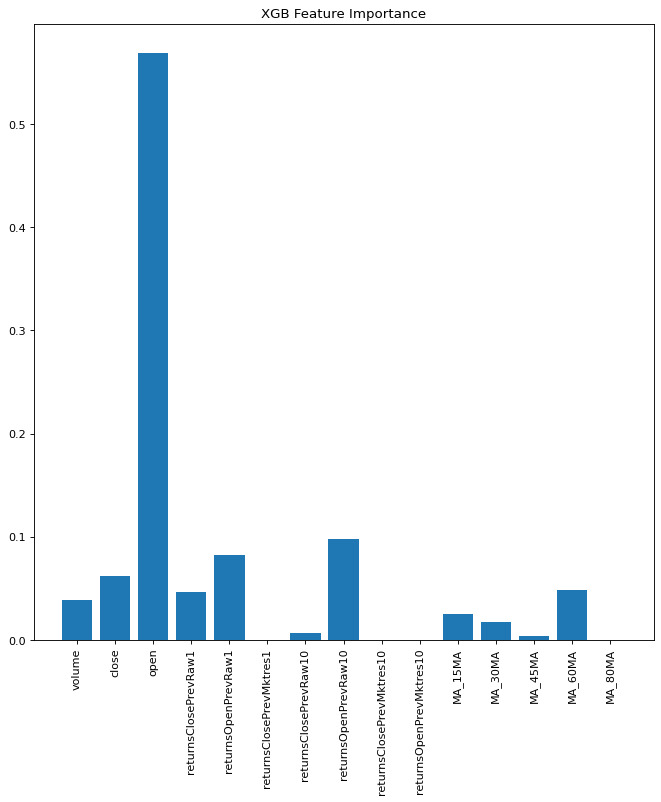

In [37]:
plt.figure(num=None, figsize=(10,10), dpi=80, facecolor='w', edgecolor = 'k')
plt.bar(range(len(model.feature_importances_)), model.feature_importances_)
plt.title("XGB Feature Importance")
plt.xticks(range(len(model.feature_importances_)), X_train.columns, rotation= 'vertical')
plt.xticks(range(len(model.feature_importances_)), X_train.columns, rotation= 'vertical')

In [38]:
class MockEnv:
    def __init__(self):
        pass

    def get_prediction_days(self):
        # For demonstration, create a loop which simulates several prediction days
        for i in range(3):
            # yield dummy data for market_df, news_df, and predictions_template_df
            yield (market_df.copy(), news_df.copy(), pd.DataFrame(columns=['confidenceValue']))

    def predict(self, predictions_df):
        print("Predictions submitted.")


env = MockEnv()
# Check to see if market_obs_df is defined.
# If it is not, we initialize it to market_df.
if 'market_obs_df' not in locals() and 'market_obs_df' not in globals():
  market_obs_df = market_df.copy()

# Get the prediction days from the mock environment.
days = env.get_prediction_days()

# Iterate through the prediction days
for market_df, news_df, predictions_template_df in days:
    market_obs_df['MA_15MA'] = market_obs_df['close'].rolling(window=15).mean()
    market_obs_df['MA_30MA'] = market_obs_df['close'].rolling(window=30).mean()
    market_obs_df['MA_45MA'] = market_obs_df['close'].rolling(window=45).mean()
    market_obs_df['MA_60MA'] = market_obs_df['close'].rolling(window=60).mean()
    market_obs_df['MA_80MA'] = market_obs_df['close'].rolling(window=80).mean()

    X_test = market_obs_df[best_cols]

    pred_1 = model.predict_proba(X_test)
    pred_2 = model_2.predict_proba(X_test)
    pred_3 = model_3.predict_proba(X_test)
    pred_4 = model_4.predict_proba(X_test)

    bagged_prediction = np.zeros((X_test.shape[0], 2))

    bagged_prediction += pred_1
    bagged_prediction += pred_2
    bagged_prediction += pred_3
    bagged_prediction += pred_4

    probability = bagged_prediction / 4

    confidence = 2 * probability[:, 1] - 1
    predictions_template_df['confidenceValue'] = confidence
    env.predict(predictions_template_df)

    print(confidence)
    print(predictions_template_df)


    print("Finished")

Predictions submitted.
[ 0.95836163  0.93656862  0.92598403 -0.70044991 -0.92906387  0.98357034
 -0.71290547  0.8778379   0.89441454  0.86594069  0.87796545 -0.79091184
  0.89688504  0.8519429   0.94294214 -0.82771344 -0.99294893  0.9396292
  0.97955716  0.92307901 -0.93598907 -0.71317014  0.75615072 -0.92829017
 -0.86918674  0.87846971  0.9245621  -0.93331595 -0.97148055  0.98015344
  0.86791372 -0.93030106  0.95509553 -0.92519868  0.89359224  0.91587985
 -0.8173881   0.95702302  0.94824243 -0.85563724  0.95027936  0.91621661
 -0.9975411  -0.99835989  0.97051954  0.94054174  0.99159288  0.87284672
  0.75104833 -0.56554636 -0.9597473   0.95589352  0.95331824 -0.9501752
 -0.91353052 -0.89657973  0.98417222  0.96444213  0.96474373  0.96976948
  0.97034204  0.98808253  0.96037519  0.970788    0.85943389 -0.79199487
  0.93039036  0.98091137  0.99187279 -0.99711068 -0.90025841  0.92595375
 -0.81287362  0.8987869   0.89608264 -0.8898948  -0.92457805  0.98016131
  0.77889407  0.99573922  0.95